In [3]:
import os
import time
import re
import dgl
import torch
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import pubchempy
import itertools

# from multiprocessing import Pool
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from rdkit.Chem import Draw, AllChem
from dgl.nn.pytorch.glob import AvgPooling
from dgllife.model import load_pretrained
from dgllife.utils import mol_to_bigraph, PretrainAtomFeaturizer, PretrainBondFeaturizer
from rdkit import Chem
from torch.utils.data import DataLoader
from rdkit.Chem import MACCSkeys
from pubchempy import get_compounds
from tqdm import tqdm

In [3]:
#数据来自Galeano等人的研究；drug;adr;freq
drug_adr = pd.read_csv('original data/Supplementary Data 1.txt', \
                   sep='\t', header=0)
drug_adr = drug_adr.drop(drug_adr.columns[-1], axis=1)
drug_atc = pd.read_csv("original data/Supplementary Data 4.txt",sep='\t',header=0)

In [4]:
print(drug_adr.columns)
drug_atc.columns

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue'], dtype='object')


Index(['CID', 'GenericName', 'ATC'], dtype='object')

In [5]:
drug1 = drug_adr['GenericName'].drop_duplicates().to_list()
drug2 = drug_atc.GenericName.to_list()

In [7]:
drug2 == drug1

True

In [8]:
data1 = pd.merge(drug_adr,drug_atc,how='left',on='GenericName')
data1.head()

,GenericName,SideeffectTerm,FrequencyRatingValue,CID,ATC
0,alfentanil,asthenia,4,51263,N01AH02
1,alfentanil,movement disorder,4,51263,N01AH02
2,alfentanil,dyskinesia,4,51263,N01AH02
3,alfentanil,tachycardia,5,51263,N01AH02
4,alfentanil,hypertension,5,51263,N01AH02


In [23]:
#数据来自ZHAO等人的研究
adr_similar_df = pd.read_csv('adr_similar_df.csv')

In [24]:
data1['GenericName'] = data1['GenericName'].str.lower()

In [25]:
data1['GenericName'] = data1['GenericName'].str.replace('.',' ')

d:\Sorftware\Anaconda\envs\drug_ade_37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [26]:
drug3 = data1[['GenericName']].drop_duplicates()

# 解析drugbank

In [2]:
tree = ET.parse("original data/full database.xml") # 读取xml文件
root = tree.getroot() # 获取根节点

In [3]:
drug_dict = {"dg_id": "",
             "dg_name": "",
             "dg_smile": "",
             "dg_ATC": "",
             "dg_synonyms": ""
             }

In [27]:
with open('pareGrug_drugbank.txt', 'w', encoding='utf-8') as writer:
	writer.write('|'.join(e for e in drug_dict) + '\n') #写入字典的键

	xmlns = '{http://www.drugbank.ca}'
	for drug in tqdm(root):
		# 解析 dg_id
		drug_bank_iter = xmlns + 'drugbank-id'
		dg_id = drug.find(drug_bank_iter)
		drug_dict['dg_id'] = dg_id.text

		# 解析 dg_name
		drug_name_iter = xmlns + 'name'
		dg_name = drug.find(drug_name_iter)
		drug_dict['dg_name'] = dg_name.text

		# 解析 SMILES
		smiles_property = drug.find(".//{http://www.drugbank.ca}property[{http://www.drugbank.ca}kind='SMILES']")
		if smiles_property is not None:
			dg_smile = smiles_property.find("{http://www.drugbank.ca}value").text
			drug_dict['dg_smile'] = dg_smile

		# 解析 ATC
		atc_iter = xmlns + 'atc-codes'
		dg_atcs = drug.find(".//" + atc_iter).findall("{http://www.drugbank.ca}atc-code")
		if dg_atcs is not None:
			dg_atc_tem=[i.attrib['code'] for i in dg_atcs]

		drug_dict['dg_ATC'] = ";".join(dg_atc_tem)


		# 解析 同义名
		drug_synms_iter = xmlns + 'synonyms'
		dg_synms = drug.find(drug_synms_iter)
		dg_synm_ = dg_synms.findall(xmlns + 'synonym')
		dg_synm = ','.join(e.text for e in dg_synm_)
		drug_dict['dg_synonyms'] = dg_synm


		writer.write('|'.join(drug_dict[tt] for tt in drug_dict) + '\n') #写入键对应的值
		#重置字典
		drug_dict = {"dg_id": "",
             "dg_name": "",
             "dg_smile": "",
             "dg_ATC": "",
             "dg_synonyms": ""
             }

100%|██████████| 15235/15235 [00:01<00:00, 11047.39it/s]


# 匹配出smiles

## drugbank database

In [28]:
drug_smiles_drugbank = pd.read_csv("pareGrug_drugbank.txt",sep='|',header=0)
drug_smiles_drugbank.rename(columns={'dg_name':'GenericName'},inplace=True)
drug_smiles_drugbank['GenericName'] = drug_smiles_drugbank['GenericName'].str.lower()
drug_smiles_drugbank['dg_synonyms'] = drug_smiles_drugbank['dg_synonyms'].str.lower()

In [29]:
drug_smiles_drugbank.head(3)

,dg_id,GenericName,dg_smile,dg_ATC,dg_synonyms
0,DB00001,lepirudin,NaN,B01AE02,"[leu1, thr2]-63-desulfohirudin,desulfatohirudi..."
1,DB00002,cetuximab,NaN,L01FE01,"cetuximab,cétuximab,cetuximabum"
2,DB00003,dornase alfa,NaN,R05CB13,deoxyribonuclease (human clone 18-1 protein mo...


In [30]:
drug_smiles_drugbank[drug_smiles_drugbank['GenericName']== 'verteporfin']

,dg_id,GenericName,dg_smile,dg_ATC,dg_synonyms
447,DB00460,verteporfin,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,S01LA01,"verteporfin,verteporfina,vertéporfine,vertepor..."


In [31]:
drug31 = pd.merge(drug3,drug_smiles_drugbank[['GenericName','dg_smile','dg_ATC']],how='left' ,on='GenericName')
drug31.head(4)

,GenericName,dg_smile,dg_ATC
0,alfentanil,CCN1N=NN(CCN2CCC(COC)(CC2)N(C(=O)CC)C2=CC=CC=C...,N01AH02
1,telithromycin,[H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[...,J01FA15
2,simeprevir,[H][C@]12C[C@]1(NC(=O)[C@]1([H])C[C@H](C[C@@]1...,G01AE10;J05AP05
3,pentamidine isethionate,NaN,NaN


In [32]:
miss_drug = drug31[drug31['dg_smile'].isna()]
# text = drug_smiles_drugbank[drug_smiles_drugbank.dg_id == 'DB04953'].dg_synonyms
print(miss_drug.head(2))
print(miss_drug.shape)
# miss_drug[miss_drug['GenericName'].isin(error_drug)] #这里的missdrug是合理的

               GenericName dg_smile dg_ATC
3  pentamidine isethionate      NaN    NaN
7               retigabine      NaN    NaN
(81, 3)


In [224]:
# pd.isna(drug_smiles_drugbank['dg_smile'][96]) == False

False

In [225]:
# index1_dicit = {}
# for i in tqdm(miss_drug.GenericName):
#     for index,j in enumerate(drug_smiles_drugbank.dg_synonyms):
#         if type(j)==str:
#             if i in j:
#                 if pd.isna(drug_smiles_drugbank['dg_smile'][index]) == False:
#                     index1_dicit[i] = index
#                     break
# print(index1_dicit)
# miss_drug.head(4)

100%|██████████| 81/81 [00:00<00:00, 346.76it/s]

{'retigabine': 4658, 'medroxyprogesterone': 588, 'octreotide': 15008, 'chlormethine': 870, 'beclometasone': 381, 'iodine ioflupane (123i)': 7859, 'chlortalidone': 299, 'corticotropin': 1262, 'glyceryl trinitrate': 711, 'indometacin': 317, 'sodium phosphate': 8367, 'hydroxycarbamide': 987, 'fampridine': 5776, 'ibandronic acid': 694, 'cyproterone': 4554, 'saccharated iron oxide': 8157, 'glutamine': 120, 'aciclovir': 562, 'heparin': 554, 'atracurium': 550, 'mercaptamine': 829, 'dicycloverine': 786, 'leuprorelin': 6, 'oxytocin': 1260, 'technetium (99mtc) tetrofosmin': 8169, 'megestrol': 339, 'podophyllotoxin': 431, 'paracetamol': 305, 'ciclosporin': 84}


,GenericName,dg_smile,dg_ATC
3,pentamidine isethionate,NaN,NaN
7,retigabine,NaN,NaN
14,medroxyprogesterone,NaN,NaN
26,octreotide,NaN,H01CB02


In [234]:
# len(index1_dicit.keys())

29

In [235]:
# #里面得到的27个药物的smiles需要人工核对是否是真的是同义名
# # pd.set_option('display.max_columns',None)
# # index1_dicit.values()
# # for key,value in index1_dicit.items():
# #     print(f"缺失的药物名{key},用以获取同义词的药物名{drug_smiles_drugbank['GenericName'][value]}")
# #将需要人工核对的药物名存入txt文件
# with open('synonyms.txt',mode='+w') as t:
#     t.write('key\t\tvalue\n')
#     for key,value in index1_dicit.items():
#         t.write(f"缺失的药物名{key}\t\t用以获取同义词的药物名{drug_smiles_drugbank['GenericName'][value]}\n")
# drug_smiles_drugbank['GenericName'][index1_dicit.values()]

In [236]:
# miss_drug['dg_smile'] = miss_drug["GenericName"].map(index1_dicit).map(drug_smiles_drugbank['dg_smile']).fillna(miss_drug['dg_smile'])
# miss_drug['dg_ATC'] = miss_drug["GenericName"].map(index1_dicit).map(drug_smiles_drugbank['dg_ATC']).fillna(miss_drug['dg_ATC'])
# miss_drug.head(4)

d:\Sorftware\Anaconda\envs\drug_ade_37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
d:\Sorftware\Anaconda\envs\drug_ade_37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,GenericName,dg_smile,dg_ATC
3,pentamidine isethionate,NaN,NaN
7,retigabine,CCOC(=O)NC1=C(N)C=C(NCC2=CC=C(F)C=C2)C=C1,N03AX21
14,medroxyprogesterone,[H][C@@]12CC[C@](OC(C)=O)(C(C)=O)[C@@]1(C)CC[C...,G03AA08;G03DA02;G03FB06;G03FA12;L02AB02;G03AA1...
26,octreotide,[90Y+3].C[C@@H](O)[C@@H](CO)NC(=O)[C@@H]1CSSC[...,H01CB02


In [35]:
drug32 = drug31.copy()
print(drug32 is drug31)
drug32.head(4)

False


,GenericName,dg_smile,dg_ATC
0,alfentanil,CCN1N=NN(CCN2CCC(COC)(CC2)N(C(=O)CC)C2=CC=CC=C...,N01AH02
1,telithromycin,[H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[...,J01FA15
2,simeprevir,[H][C@]12C[C@]1(NC(=O)[C@]1([H])C[C@H](C[C@@]1...,G01AE10;J05AP05
3,pentamidine isethionate,NaN,NaN


In [36]:
print(drug32[drug32['dg_smile'].isna()].shape)
drug32[drug31['dg_smile'].isna()]
# drug32[drug31['dg_smile'].isna()].shape

(81, 3)


,GenericName,dg_smile,dg_ATC
3,pentamidine isethionate,NaN,NaN
7,retigabine,NaN,NaN
14,medroxyprogesterone,NaN,NaN
26,octreotide,NaN,H01CB02
29,rasburicase,NaN,V03AF07;M04AX01
...,...,...,...
730,podophyllotoxin,NaN,NaN
742,paracetamol,NaN,NaN
745,conjugated estrogens,NaN,G03CA57;G03CC07
757,aclidinium bromide,NaN,NaN


### 从pubchem查找缺失的smiles

In [21]:
#用以从pubchem找寻smiles的函数
# 	return maccs_str
def search_from_Pubchem(name):
    time.sleep(2)
    if name == None:
        pass
    else:
        try:
            pubresu = get_compounds(name, 'name')[0]
        except:
            # row['activesubstancename'] = drug
            smiles=None
        else:
            # row['activesubstancename'] = drug
            if pubresu.isomeric_smiles is not None:
                smiles = pubresu.isomeric_smiles
            elif pubresu.canonical_smiles is not None:
                smiles = pubresu.canonical_smiles
            else:
                smiles=None
        return smiles

miss_smile={}
for i in tqdm(miss_drug['GenericName']):
	miss_smile[i]=search_from_Pubchem(i)

100%|██████████| 81/81 [05:08<00:00,  3.81s/it]


In [22]:
print(len(miss_smile.values()))
miss_smile

81


{'pentamidine isethionate': 'C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N.C(CS(=O)(=O)O)O.C(CS(=O)(=O)O)O',
 'retigabine': 'CCOC(=O)NC1=C(C=C(C=C1)NCC2=CC=C(C=C2)F)N',
 'medroxyprogesterone': 'C[C@H]1C[C@@H]2[C@H](CC[C@]3([C@H]2CC[C@@]3(C(=O)C)O)C)[C@@]4(C1=CC(=O)CC4)C',
 'octreotide': 'C[C@H]([C@H]1C(=O)N[C@@H](CSSC[C@@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N[C@H](C(=O)N1)CCCCN)CC2=CNC3=CC=CC=C32)CC4=CC=CC=C4)NC(=O)[C@@H](CC5=CC=CC=C5)N)C(=O)N[C@H](CO)[C@@H](C)O)O',
 'rasburicase': None,
 'insulin glargine': 'CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[C@@H](CSSC[C@@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CSSC[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)CO)CC(C)C)CC3=CC=C(C=C3)O)CCC(=O)N)CC(C)C)CCC(=O)O)CC(=O)N)CC4=CC=C(C=C4)O)C(=O)NCC(=O)O)C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](CC5=

In [23]:
#将更新的smiles合并到之前归一化失败的里面
for i in range(drug32.shape[0]):
    if pd.isna(drug32.iloc[i,1])== True:
        drug32.iloc[i,1] = miss_smile[drug32.iloc[i,0]]
drug32[drug32['dg_smile'].isna()].shape

(20, 3)

### 对smiles进行规范

drug32里面有缺失的smiles55

In [37]:
def unify_smiles(smiles):
    # 将 SMILES 字符串转换为分子对象
    if type(smiles) == str:
        mol = Chem.MolFromSmiles(smiles)
    else:
        mol = None
    if mol is None:
        return None  # 如果无法转换为分子对象，则返回 None
    # 将分子对象转换回标准化的 SMILES 格式
    standardized_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    return standardized_smiles
drug32['dg_smile_unif'] = drug32['dg_smile'].map(unify_smiles)
# miss_simle_drug=drug32[drug32['dg_smile'].isnull()]['GenericName'].unique()

In [38]:
print(drug32[drug32['dg_smile'].isna()].shape)
drug32[drug32['dg_smile_unif'].isna()].shape #有三个药物从drugbank中导入的无法进行mol转换

(81, 4)


(84, 4)

,GenericName,dg_smile,dg_ATC,dg_smile_unif
153,oxaliplatin,[H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[Pt]...,L01XA03,None
549,carboplatin,[H][N]([H])([H])[Pt]1(OC(=O)C2(CCC2)C(=O)O1)[N...,L01XA02,None
672,temoporfin,OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)...,L01XD05,None


In [26]:
drug32[drug32['dg_smile_unif'].isna()]['GenericName']

29                        rasburicase
61                       eptifibatide
96                    porfimer sodium
141                        ofatumumab
153                       oxaliplatin
202                    insulin aspart
225                       ustekinumab
298       pentosan polysulfate sodium
338           lamivudine and abacavir
400         radium (223ra) dichloride
415                       teduglutide
455                           heparin
464                     muromonab-cd3
521                       pegvisomant
540                           albumin
549                       carboplatin
552    technetium (99mtc) exametazime
556        salmeterol and fluticasone
564                       romiplostim
577                          secretin
580                             mesna
672                        temoporfin
742                       paracetamol
Name: GenericName, dtype: object

对规范化里面的smiles再进行一次pubchem搜索

In [27]:
miss_smile={}
for i in tqdm(drug32[drug32['dg_smile_unif'].isna()]['GenericName']):
	miss_smile[i]=search_from_Pubchem(i)

100%|██████████| 23/23 [01:24<00:00,  3.67s/it]


In [28]:
print(len(miss_smile.values()))
miss_smile

23


{'rasburicase': None,
 'eptifibatide': 'C1C[C@H]2C(=O)N[C@@H](CSSCCC(=O)N[C@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N2C1)CC3=CNC4=CC=CC=C43)CC(=O)O)CCCCN=C(N)N)C(=O)N',
 'porfimer sodium': None,
 'ofatumumab': None,
 'oxaliplatin': 'C1CC[C@H]([C@@H](C1)[NH-])[NH-].C(=O)(C(=O)O)O.[Pt+2]',
 'insulin aspart': None,
 'ustekinumab': None,
 'pentosan polysulfate sodium': None,
 'lamivudine and abacavir': None,
 'radium (223ra) dichloride': None,
 'teduglutide': 'CC[C@H](C)[C@@H](C(=O)N[C@@H]([C@@H](C)O)C(=O)N[C@@H](CC(=O)O)C(=O)O)NC(=O)[C@H](CCCCN)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC1=CNC2=CC=CC=C21)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H](CC3=CC=CC=C3)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H](C)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H](CC(=O)O)NC(=O)[C@H](CC(C)C)NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H](CCSC)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](

In [29]:
drug32.columns

Index(['GenericName', 'dg_smile', 'dg_ATC', 'dg_smile_unif'], dtype='object')

In [30]:
#将更新的smiles合并到之前归一化失败的里面
for i in range(drug32.shape[0]):
    if pd.isna(drug32.iloc[i,3])== True:
        drug32.iloc[i,3] = miss_smile[drug32.iloc[i,0]]
drug32[drug32['dg_smile_unif'].isna()].shape

(16, 4)

再次进行规范化看是否是所有药物已经规范化

In [31]:
drug_test = drug32['dg_smile_unif'].map(unify_smiles)
pd.value_counts(drug_test.isna())

False    743
True      16
Name: dg_smile_unif, dtype: int64

In [32]:
drug_complete = drug32.dropna(subset=['dg_smile_unif'])
drug_complete.shape

(743, 4)

In [353]:
# error_drug

['aciclovir', 'heparin', 'podophyllotoxin', 'atracurium']

In [33]:
print(len(drug_complete['dg_smile_unif'].unique()))
len(drug_complete['GenericName'].unique())

743


743

In [34]:
data1['GenericName'] = data1['GenericName'].str.lower()
data1['SideeffectTerm'] = data1['SideeffectTerm'].str.lower()
data1.head(2)

,GenericName,SideeffectTerm,FrequencyRatingValue,CID,ATC
0,alfentanil,asthenia,4,51263,N01AH02
1,alfentanil,movement disorder,4,51263,N01AH02


In [35]:
adr_similar_df1 = adr_similar_df.drop(labels=adr_similar_df.columns[0],axis=1)
adr_similar_df1['adr_name'] =adr_similar_df1['adr_name'].str.lower() 
adr_similar_df1.head(4)

,adr_name,adr_similar
0,abdominal discomfort,"[1.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.2, 0.0, ..."
1,abdominal distension,"[0.2, 1.0, 0.2, 0.2, 0.2, 0.0, 0.0, 0.2, 0.0, ..."
2,abdominal pain,"[0.2, 0.2, 1.0, 0.4666666666666667, 0.46666666..."
3,abdominal pain lower,"[0.2, 0.2, 0.4666666666666667, 1.0, 0.46666666..."


In [36]:
drug_complete['GenericName'] = drug_complete['GenericName'].str.lower()
drug_complete.head(3)

d:\Sorftware\Anaconda\envs\drug_ade_37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,GenericName,dg_smile,dg_ATC,dg_smile_unif
0,alfentanil,CCN1N=NN(CCN2CCC(COC)(CC2)N(C(=O)CC)C2=CC=CC=C...,N01AH02,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1
1,telithromycin,[H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[...,J01FA15,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...
2,simeprevir,[H][C@]12C[C@]1(NC(=O)[C@]1([H])C[C@H](C[C@@]1...,G01AE10;J05AP05,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...


In [37]:
drug_complete.to_csv('drug_complete.csv',index=False)

In [38]:
drug_complete.columns

Index(['GenericName', 'dg_smile', 'dg_ATC', 'dg_smile_unif'], dtype='object')

# 整理数据集，目标数据集

# drug adr freq smile adr_similar_feature

In [39]:
data2 = pd.merge(data1.iloc[:,0:3], drug_complete.iloc[:,[0,3]],how='left',on='GenericName')
data2.head(3)

,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1
1,alfentanil,movement disorder,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1
2,alfentanil,dyskinesia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1


In [41]:
adr_similar_df1.rename(columns={'adr_name': 'SideeffectTerm'},inplace=True)
adr_similar_df1.columns

Index(['SideeffectTerm', 'adr_similar'], dtype='object')

In [42]:
data2.columns

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif'],
      dtype='object')

In [44]:
data2 = pd.merge(data2, adr_similar_df1,how='left',on='SideeffectTerm')

In [45]:
data2.head(3)

,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,alfentanil,movement disorder,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0540540540540..."
2,alfentanil,dyskinesia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0540540540540..."


In [46]:
data3 = data2.dropna(subset=['dg_smile_unif'],axis=0)
data3.shape
len(data3['GenericName'].unique())

743

In [423]:
data3.to_csv('data3.csv',index=False)

In [47]:
len(data3['GenericName'].unique())
len(data3['SideeffectTerm'].unique())

994

# 提取结构， 圆形， 拓扑指纹

## 药效团指纹其中有许多药物无法获取，

## 蛋白质配体相互作用指纹需要与蛋白质连用；形状指纹暂时没有找到方法使用

In [11]:
data3=pd.read_csv('./data3.csv',header=0)
print(data3.columns)
data3.iloc[15:20,]

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif', 'adr_similar'],
      dtype='object')


,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar
15,alfentanil,hypotension,5,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,alfentanil,muscle rigidity,5,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0454545454545..."
17,telithromycin,flatulence,4,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,"[0.2, 0.4666666666666667, 0.2, 0.2, 0.2, 0.0, ..."
18,telithromycin,diarrhoea,4,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,"[0.06666666666666667, 0.06666666666666667, 0.0..."
19,telithromycin,dysgeusia,4,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,"[0.05405405405405406, 0.05405405405405406, 0.0..."


In [12]:
#获取smiles编码
smiles_all=data3[['GenericName','dg_smile_unif']].drop_duplicates()
# smiles_all=data3['dg_smile_unif'].drop_duplicates()
smiles_all.head(4)

,GenericName,dg_smile_unif
0,alfentanil,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1
17,telithromycin,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...
29,simeprevir,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...
44,pentamidine isethionate,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1.O=S(=O...


In [ ]:
def getcompund(smiles,drugname):
    try:
        compound = pubchempy.get_compounds(drugname,'name')[0]
    except:
        compound = pubchempy.get_compounds(smiles,'smiles')[0]
    pubchem = compound.cactvs_fingerprint
    pubchem = np.array([int(i) for i in pubchem])
    return list(pubchem)

In [ ]:
pubchemfinger ={}
for i in tqdm(range(smiles_all.shape[0])):
    pubchemfinger[smiles_all.iloc[i,0]]= getcompund(smiles_all.iloc[i,1], smiles_all.iloc[i,0])

In [ ]:
def fingerpint(smiles, drugname):
    #Macc
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    Macc = AllChem.GetMACCSKeysFingerprint(mol)
    Macc = np.array(Macc)
    
    #pubchem 有部分药物没有查询到该指纹
    # try:
    #     compund = pubchempy.get_compounds(drugname,'name')
    #     pubchem = compund[0].cactvs_fingerprint
    #     pubchem = np.array([int(i) for i in pubchem])
    # except:
    #     pubchem = None

    #Morgan
    Morgan = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    Morgan = np.array(Morgan)
    
    #rdkit(Topological)
    #rdkit独有的灵感来源于daylight
    Rtoplo = Chem.RDKFingerprint(mol)
    Rtoplo = np.array(Rtoplo)
    
    # #pharmacophore
    # AllChem.EmbedMolecule(mol)
    # factory = Gobbi_Pharm2D.factory
    # #calc 3d p4 fp
    # phar = Generate.Gen2DFingerprint(mol, factory, dMat = Chem.Get3DDistanceMatrix(mol))
    # phar = [int(i) for i in phar.ToBitString()]
    # phar = np.array(phar)
    return list(Macc), list(Morgan), list(Rtoplo)

In [ ]:
Macc = {}
Morgan = {}
Rtoplo = {}
for i in tqdm(range(0, smiles_all.shape[0])):
    Macc[smiles_all.iloc[i,0]], Morgan[smiles_all.iloc[i,0]], Rtoplo[smiles_all.iloc[i,0]] = fingerpint(smiles=smiles_all.iloc[i,1],drugname=smiles_all.iloc[i,0])

In [ ]:
smiles_all['Macc'] = smiles_all['GenericName'].map(lambda x: Macc[x])
smiles_all['pubchem'] = smiles_all['GenericName'].map(lambda x: pubchemfinger[x])
smiles_all['Morgan'] = smiles_all['GenericName'].map(lambda x: Morgan[x])
smiles_all['Rtoplo'] = smiles_all['GenericName'].map(lambda x: Rtoplo[x])
smiles_all.head(3)

In [ ]:
data4 = pd.merge(data3, smiles_all.iloc[:,[0,2,3,4,5]], how='left', on='GenericName')
data4.head(2)

In [ ]:
data4.to_csv('data4.csv', index=False)

In [ ]:
data4.isnull().apply(sum, axis=0)

# 根据指纹计算药物的相似性

## 根据相似性进行采样NSS数据集

#### 这里计算可以计算所有药物的相似性，后面模型的时候只能计算所有训练集的药物的相似性

In [2]:
data4 = pd.read_csv('./data4.csv',header=0)
print(data4.columns)
data4.head(3)

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif', 'adr_similar', 'Macc', 'pubchem', 'Morgan', 'Rtoplo'],
      dtype='object')


,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar,Macc,pubchem,Morgan,Rtoplo
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."
1,alfentanil,movement disorder,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0540540540540...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."
2,alfentanil,dyskinesia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0540540540540...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."


In [4]:
drug_smiles = data4[['GenericName','dg_smile_unif']].drop_duplicates()
print(drug_smiles.head(2))
drug_smiles.shape

      GenericName                                      dg_smile_unif
0      alfentanil   CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1
17  telithromycin  CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...


(743, 2)

In [5]:
len(drug_smiles.dg_smile_unif) == len(drug_smiles.GenericName)

True

In [24]:
def fingersimilar(smiles1, smiles2):
    n = 1
    similar_macc = []
    similar_morgan = []
    similar_rtoplo = []
    for sm in smiles1:
        n = n+1
        print("\r", end="")
        print("drug: {}: ".format(n), "▋" * (n // 2), end="")
        sm1 = sm
        mol1 = Chem.MolFromSmiles(sm1)
        sm1_similar_macc = []
        sm1_similar_morgan = []
        sm1_similar_rtoplo = []
        smili_len = len(smiles2)
        
        fpgen_morgan = AllChem.GetMorganGenerator(radius=1, fpSize= 2048) #morgan
        fpgen_rtoplo = AllChem.GetRDKitFPGenerator() #rdkit 
        fpmacc1,fpmrogan1,fptoplo1 = Chem.MACCSkeys.GenMACCSKeys(mol1), fpgen_morgan.GetSparseCountFingerprint(mol1), fpgen_rtoplo.GetFingerprint(mol1)
        for i in range(smili_len):
            sm2 = smiles2[i]
            tem_mol = Chem.MolFromSmiles(sm2) #需要计算相似度的smiles集合
            #从分子得到指纹
            fpgen_morgan = AllChem.GetMorganGenerator(radius=1, fpSize= 2048)
            fpgen_rtoplo = AllChem.GetRDKitFPGenerator()
            fpmacc2,fpmrogan2,fptoplo2 = Chem.MACCSkeys.GenMACCSKeys(tem_mol), fpgen_morgan.GetSparseCountFingerprint(tem_mol), fpgen_rtoplo.GetFingerprint(tem_mol)
            
            #计算相似性
            smililar_macc = DataStructs.TanimotoSimilarity(fpmacc1,fpmacc2)
            smililar_morgan = DataStructs.TanimotoSimilarity(fpmrogan1,fpmrogan2)
            smililar_rtoplo = DataStructs.TanimotoSimilarity(fptoplo1,fptoplo2)
            sm1_similar_macc.append(smililar_macc)
            sm1_similar_morgan.append(smililar_morgan)
            sm1_similar_rtoplo.append(smililar_rtoplo)
        similar_macc.append(sm1_similar_macc), similar_morgan.append(sm1_similar_morgan), similar_rtoplo.append(sm1_similar_rtoplo)
    return similar_macc, similar_morgan, similar_rtoplo

In [6]:
# def parallel_fingersimilar(x, drug_smiles_list):
#     return fingersimilar(x, drug_smiles_list)

# def apply_parallel(df):
#     with Pool() as pool:
#         print("----1----")
#         result = pool.starmap(parallel_fingersimilar, zip(df, [df.tolist()]*len(df)))
#     return result

# # 假设 drug_smiles 是你的 DataFrame
# drug_smiles = pd.DataFrame({'dg_smile_unif': ['smile1', 'smile2', 'smile3', 'smile4', 'smile5']})

# ttt, ttt1, ttt2 = apply_parallel(drug_smiles['dg_smile_unif'])


----1----


In [25]:
ttt,ttt1,ttt2 =fingersimilar(drug_smiles['dg_smile_unif'].tolist(), drug_smiles['dg_smile_unif'].tolist())
print("耗时38m")

drug: 744:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

In [52]:
com_similar = [np.mean(x, axis=0) for x in zip(ttt ,ttt1, ttt2)]

In [59]:
drug_smiles['macc_simi'], drug_smiles['morgan_simi'], drug_smiles['rtoplo_simi'],  drug_smiles['com_simi']  = ttt, ttt1, ttt2, com_similar
print(drug_smiles.columns) 
drug_smiles.head(3)

Index(['GenericName', 'dg_smile_unif', 'macc_simi', 'morgan_simi',
       'rtoplo_simi', 'com_simi'],
      dtype='object')


,GenericName,dg_smile_unif,macc_simi,morgan_simi,rtoplo_simi,com_simi
0,alfentanil,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[1.0, 0.6904761904761905, 0.5784313725490197, ...","[1.0, 0.23076923076923078, 0.20588235294117646...","[1.0, 0.38391224862888484, 0.40382387022016225...","[1.0, 0.4350525566247687, 0.39604586523678614,..."
17,telithromycin,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,"[0.6904761904761905, 1.0, 0.5980392156862745, ...","[0.23076923076923078, 1.0, 0.22905027932960895...","[0.38391224862888484, 1.0, 0.5787211176786674,...","[0.4350525566247687, 1.0, 0.4686035375648503, ..."
29,simeprevir,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,"[0.5784313725490197, 0.5980392156862745, 1.0, ...","[0.20588235294117646, 0.22905027932960895, 1.0...","[0.40382387022016225, 0.5787211176786674, 1.0,...","[0.39604586523678614, 0.4686035375648503, 1.0,..."


In [194]:
data5 = pd.merge(data4, drug_smiles.iloc[:,[0,2,3,4,5]], how='left', on='GenericName')
data5.to_csv('data5.csv', index=False)

In [193]:
data5.isnull().apply(sum, axis=0)

GenericName             0
SideeffectTerm          0
FrequencyRatingValue    0
dg_smile_unif           0
adr_similar             0
Macc                    0
pubchem                 0
Morgan                  0
Rtoplo                  0
macc_simi               0
morgan_simi             0
rtoplo_simi             0
com_simi                0
dtype: int64

In [74]:
data5.columns

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif_x', 'adr_similar', 'Macc', 'pubchem', 'Morgan', 'Rtoplo',
       'dg_smile_unif_y', 'macc_simi', 'morgan_simi', 'rtoplo_simi',
       'com_simi'],
      dtype='object')

# 构建PPS集

In [195]:
PPS = data5.copy()
PPS['association'] = 1
PPS.head(1)

,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar,Macc,pubchem,Morgan,Rtoplo,macc_simi,morgan_simi,rtoplo_simi,com_simi,association
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1.0, 0.6904761904761905, 0.5784313725490197, ...","[1.0, 0.23076923076923078, 0.20588235294117646...","[1.0, 0.38391224862888484, 0.40382387022016225...","[1.0, 0.4350525566247687, 0.39604586523678614,...",1


In [202]:
PPS.shape

(36895, 14)

# 构建NNS集

#### 先构造一个all数据集

In [211]:
drug_smiles.GenericName
adr_all = data5.SideeffectTerm.unique()
len(adr_all)

994

In [223]:
all_drug_adr_paire = pd.DataFrame((list(itertools.product(drug_smiles.GenericName, adr_all))))
all_drug_adr_paire.rename(columns={0 : 'GenericName',
                                   1: 'SideeffectTerm'}, inplace=True)
all_drug_adr_paire.head(2)

,GenericName,SideeffectTerm
0,alfentanil,asthenia
1,alfentanil,movement disorder


In [244]:
# 将 all_drug_adr_pair 数据集和 pps_data 数据集按照药物和ADR列进行合并，并排除掉重复的行
filtered_drug_adr_pair = all_drug_adr_paire.merge(PPS, on=['GenericName', 'SideeffectTerm'], how='left', indicator=True)
NNS_all = filtered_drug_adr_pair[filtered_drug_adr_pair['_merge'] == 'left_only']
del filtered_drug_adr_pair
NNS_all['association'] = 0
NNS_all.drop(columns='_merge', axis=0, inplace=True)
print(NNS_all.shape)
NNS_all.columns

(701647, 14)


Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif', 'adr_similar', 'Macc', 'pubchem', 'Morgan', 'Rtoplo',
       'macc_simi', 'morgan_simi', 'rtoplo_simi', 'com_simi', 'association'],
      dtype='object')

In [245]:
NNS_all.to_csv('NNS_all.csv', index=False)
PPS.to_csv('PPS.csv', index=False)

In [231]:
print(NNS_all.shape)
print(PPS.shape)
all_drug_adr_paire.shape

(701647, 15)
(36895, 14)


(738542, 2)

In [196]:
pd.value_counts(PPS.GenericName)

pregabalin              536
paroxetine              408
venlafaxine             400
ropinirole              396
escitalopram            383
                       ... 
umeclidinium bromide      5
alprostadil               5
allopurinol               5
tofacitinib               5
clevidipine               4
Name: GenericName, Length: 743, dtype: int64

# 计算药效团指纹

In [14]:
data5 = pd.read_csv('data5.csv', header=0)
data5.head(1)

,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar,Macc,pubchem,Morgan,Rtoplo,macc_simi,morgan_simi,rtoplo_simi,com_simi
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1.0, 0.6904761904761905, 0.5784313725490197, ...","[1.0, 0.23076923076923078, 0.20588235294117646...","[1.0, 0.38391224862888484, 0.40382387022016225...",[1. 0.43505256 0.39604587 0.20957798 0...


In [15]:
_drug_complete = data5.drop_duplicates(subset=['GenericName'])
_drug_complete.shape

(743, 13)

In [16]:
def phamfp(smiles):
    #Macc
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    #pharmacophore
    phar = AllChem.GetErGFingerprint(mol,fuzzIncrement=0.3,maxPath=21,minPath=1)
    return list(phar)

In [17]:
_drug_complete['pharmfp'] = _drug_complete.iloc[:,3].apply(phamfp)
_drug_complete.head(5)

d:\Sorftware\Anaconda\envs\drug_ade_37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar,Macc,pubchem,Morgan,Rtoplo,macc_simi,morgan_simi,rtoplo_simi,com_simi,pharmfp
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1.0, 0.6904761904761905, 0.5784313725490197, ...","[1.0, 0.23076923076923078, 0.20588235294117646...","[1.0, 0.38391224862888484, 0.40382387022016225...",[1. 0.43505256 0.39604587 0.20957798 0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,telithromycin,flatulence,4,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,"[0.2, 0.4666666666666667, 0.2, 0.2, 0.2, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.6904761904761905, 1.0, 0.5980392156862745, ...","[0.23076923076923078, 1.0, 0.22905027932960895...","[0.38391224862888484, 1.0, 0.5787211176786674,...",[0.43505256 1. 0.46860354 0.20399441 0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
29,simeprevir,asthenia,5,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.5784313725490197, 0.5980392156862745, 1.0, ...","[0.20588235294117646, 0.22905027932960895, 1.0...","[0.40382387022016225, 0.5787211176786674, 1.0,...",[0.39604587 0.46860354 1. 0.24229096 0...,"[0.0, 0.3, 1.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
44,pentamidine isethionate,asthenia,5,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1.O=S(=O...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, ...","[0.3333333333333333, 0.32673267326732675, 0.42...","[0.15, 0.14792899408284024, 0.1375, 1.0, 0.043...","[0.14540059347181009, 0.1373215499660095, 0.15...",[0.20957798 0.20399441 0.24229096 1. 0...,"[0.6, 2.0, 1.2, 2.0, 0.6, 0.0, 0.0, 0.0, 0.0, ..."
53,penicillamine,leukopenia,4,CC(C)(S)[C@@H](N)C(=O)O,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...","[0.15, 0.189873417721519, 0.18947368421052632,...","[0.0684931506849315, 0.03076923076923077, 0.05...","[0.08244111349036402, 0.0784452296819788, 0.07...",[0.10031142 0.09969596 0.10423921 0.10542887 1...,"[0.0, 0.6, 2.3, 1.6, 0.3, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
data6 = data5.copy()
data6 = pd.merge(data5, _drug_complete[['GenericName','pharmfp']], how='left', on='GenericName')
data6.head(2)

,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar,Macc,pubchem,Morgan,Rtoplo,macc_simi,morgan_simi,rtoplo_simi,com_simi,pharmfp
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1.0, 0.6904761904761905, 0.5784313725490197, ...","[1.0, 0.23076923076923078, 0.20588235294117646...","[1.0, 0.38391224862888484, 0.40382387022016225...",[1. 0.43505256 0.39604587 0.20957798 0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,alfentanil,movement disorder,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0540540540540...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1.0, 0.6904761904761905, 0.5784313725490197, ...","[1.0, 0.23076923076923078, 0.20588235294117646...","[1.0, 0.38391224862888484, 0.40382387022016225...",[1. 0.43505256 0.39604587 0.20957798 0...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 计算pharmfp的余弦相似度

In [19]:
def caculate_cos_sim(fp, fp_list):
    _fp = [fp for i in range(len(fp_list))]
    _dot = [np.dot(i,j) for i,j in zip(_fp, fp_list)]
    _norm1 = [np.linalg.norm(i) for i in _fp]
    _norm2 = [np.linalg.norm(i) for i in fp_list]
    _div = [i*j for i,j in zip(_norm1, _norm2)]
    _result = [i/j for i,j in zip(_dot, _div)]
    return _result

In [21]:
data6 = data6[['GenericName', 'SideeffectTerm', 'FrequencyRatingValue','dg_smile_unif', 'adr_similar', 'Macc', 'pubchem', 'Morgan', 'Rtoplo', 'pharmfp']]
print(data6.columns)
data6.shape

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif', 'adr_similar', 'Macc', 'pubchem', 'Morgan', 'Rtoplo',
       'pharmfp'],
      dtype='object')


(36895, 10)

In [22]:
data6.to_csv('data6.csv', index=False)

# 计算药物的已知ADR相似性

# bilstm提取药物的smiles字符特征

# 重构神经网络提取ADR的特征

草稿

In [17]:
mol = Chem.MolFromSmiles(smiles_all.iloc[36,1])
AllChem.EmbedMolecule(mol)
factory = Gobbi_Pharm2D.factory
#calc 3d p4 fp
phar = Generate.Gen2DFingerprint(mol, factory, dMat = Chem.Get3DDistanceMatrix(mol))
phar = [int(i) for i in phar.ToBitString()]
phar = np.array(phar)

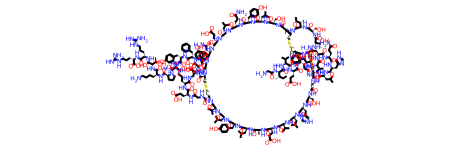

In [16]:
mol = Chem.MolFromSmiles(smiles_all.iloc[37,1])
mol

In [374]:
print(drug_complete.iloc[99,1])
drug_complete.iloc[99,3]

[H][C@]12CN(C[C@@]1([H])NCCC2)C1=C(F)C=C2C(=O)C(=CN(C3CC3)C2=C1OC)C(O)=O


'COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12'

In [375]:
mol = Chem.MolFromSmiles('[H][C@]12CN(C[C@@]1([H])NCCC2)C1=C(F)C=C2C(=O)C(=CN(C3CC3)C2=C1OC)C(O)=O')
Chem.MolToSmiles(mol, isomericSmiles=True)

'COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12'

In [242]:
#规范化的列缺失，而原始的smiles有值
drug32[drug32['dg_smile_unif'].isna() & ~drug32['dg_smile'].isna()]
# drug32[drug32['dg_smile_unif'].isna() & ~drug32['dg_smile'].isna()].iloc[1,1]

,GenericName,dg_smile,dg_ATC,dg_smile_unif
153,oxaliplatin,[H][N]1([H])[C@@H]2CCCC[C@H]2[N]([H])([H])[Pt]...,L01XA03,None
549,carboplatin,[H][N]([H])([H])[Pt]1(OC(=O)C2(CCC2)C(=O)O1)[N...,L01XA02,None
672,temoporfin,OC1=CC=CC(=C1)C-1=C2\CCC(=N2)\C(=C2/N\C(\C=C2)...,L01XD05,None


In [255]:
drug32[drug32['dg_smile_unif'].isna()].shape

(15, 4)

In [206]:
drug32.columns

Index(['GenericName', 'dg_smile', 'dg_ATC', 'dg_smile_unif'], dtype='object')

In [248]:
drug_complete = drug32.dropna(subset=['dg_smile_unif'])
drug_complete.shape

(744, 4)

In [251]:
miss_drug.shape

(81, 3)

In [249]:
#再利用同义词进行匹配的时候出现问题的药物
err_durg=['octreotide','corticotropin','heparin','atracurium','oxytocin','sodium phosphate','aciclovir','podophyllotoxin']

In [250]:
search_from_Pubchem(err_durg[0])

'C[C@H]([C@H]1C(=O)N[C@@H](CSSC[C@@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N[C@H](C(=O)N1)CCCCN)CC2=CNC3=CC=CC=C32)CC4=CC=CC=C4)NC(=O)[C@@H](CC5=CC=CC=C5)N)C(=O)N[C@H](CO)[C@@H](C)O)O'

In [ ]:

drug_complete[drug_complete['GenericName']=='aciclovir']#.iloc[0,1]

In [77]:
drug_smiles_drugbank[drug_smiles_drugbank['GenericName'].isin(['aciclovir','valaciclovir','fondaparinux','heparin','teniposide','podophyllotoxin','cisatracurium','atracurium'])]

,dg_id,GenericName,dg_smile,dg_ATC,dg_synonyms
431,DB00444,teniposide,[H][C@]12COC(=O)[C@]1([H])[C@H](C1=CC(OC)=C(O)...,L01CB02,"4'-demethylepipodophyllotoxin 9-(4,6-o-(r)-2-t..."
550,DB00565,cisatracurium,COC1=CC2=C(C=C1OC)[C@@H](CC1=CC(OC)=C(OC)C=C1)...,M03AC11,"(1r,2r,1'r,2'r)-2,2'-{pentane-1,5-diylbis[oxy(..."
554,DB00569,fondaparinux,CO[C@H]1O[C@H](COS(O)(=O)=O)[C@@H](O[C@@H]2O[C...,B01AX05,natural heparin pentasaccharide
562,DB00577,valaciclovir,CC(C)[C@H](N)C(=O)OCCOCN1C=NC2=C1NC(N)=NC2=O,J05AB11,l-valine ester with 9-((2-hydroxyethoxy)methyl...
1088,DB01109,heparin,NaN,B01AB51;C05BA03;S01XA14;C05BA53;B01AB01,"eparina,heparina,heparine,heparinic acid,hepar..."
11270,DB13295,atracurium,NaN,M03AC04,NaN


In [78]:
drug_complete[drug_complete['dg_smile_unif'].duplicated(keep=False)].sort_values('dg_smile_unif')
#错误匹配的药物列表
error_drug = ['aciclovir','heparin','podophyllotoxin','atracurium']

In [82]:
drug31[drug31['GenericName'].isin(error_drug)]

,GenericName,dg_smile,dg_ATC
449,aciclovir,NaN,NaN
455,heparin,NaN,B01AB51;C05BA03;S01XA14;C05BA53;B01AB01
482,atracurium,NaN,M03AC04
730,podophyllotoxin,NaN,NaN


In [79]:
drug33 = drug32.iloc[:,[0,3,2]]
drug33.columns = ['GenericName','dg_smile_unif','dg_ATC_drugbank']
drug33.head(2)

,GenericName,dg_smile_unif,dg_ATC_drugbank
0,alfentanil,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,N01AH02
1,telithromycin,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,J01FA15


In [85]:
drug33.dropna(subset=['GenericName','dg_smile_unif']).iloc[3,1]

'C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N.C(CS(=O)(=O)O)O.C(CS(=O)(=O)O)O'

In [93]:
drug32

,GenericName,dg_smile,dg_ATC,dg_smile_unif
0,alfentanil,CCN1N=NN(CCN2CCC(COC)(CC2)N(C(=O)CC)C2=CC=CC=C...,N01AH02,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1
1,telithromycin,[H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[...,J01FA15,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...
2,simeprevir,[H][C@]12C[C@]1(NC(=O)[C@]1([H])C[C@H](C[C@@]1...,G01AE10;J05AP05,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...
3,pentamidine isethionate,NaN,NaN,C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N....
4,penicillamine,[H][C@](N)(C(O)=O)C(C)(C)S,M01CC01,CC(C)(S)[C@@H](N)C(=O)O
...,...,...,...,...
754,rufinamide,NC(=O)C1=CN(CC2=C(F)C=CC=C2F)N=N1,N03AF03,NC(=O)c1cn(Cc2c(F)cccc2F)nn1
755,tafluprost,CC(C)OC(=O)CCC\C=C/C[C@H]1[C@@H](O)C[C@@H](O)[...,S01EE05,CC(C)OC(=O)CCC/C=C\C[C@@H]1[C@@H](/C=C/C(F)(F)...
756,cabazitaxel,[H][C@]12[C@H](OC(=O)C3=CC=CC=C3)[C@]3(O)C[C@H...,L01CD04,CO[C@H]1C(=O)[C@]2(C)[C@@H](OC)C[C@H]3OC[C@@]3...
757,aclidinium bromide,NaN,NaN,C1C[N+]2(CCC1[C@H](C2)OC(=O)C(C3=CC=CS3)(C4=CC...


In [87]:
drug33.dropna(subset=['GenericName','dg_smile_unif'])

,GenericName,dg_smile_unif,dg_ATC_drugbank
0,alfentanil,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,N01AH02
1,telithromycin,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,J01FA15
2,simeprevir,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,G01AE10;J05AP05
3,pentamidine isethionate,C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N....,NaN
4,penicillamine,CC(C)(S)[C@@H](N)C(=O)O,M01CC01
...,...,...,...
754,rufinamide,NC(=O)c1cn(Cc2c(F)cccc2F)nn1,N03AF03
755,tafluprost,CC(C)OC(=O)CCC/C=C\C[C@@H]1[C@@H](/C=C/C(F)(F)...,S01EE05
756,cabazitaxel,CO[C@H]1C(=O)[C@]2(C)[C@@H](OC)C[C@H]3OC[C@@]3...,L01CD04
757,aclidinium bromide,C1C[N+]2(CCC1[C@H](C2)OC(=O)C(C3=CC=CS3)(C4=CC...,NaN


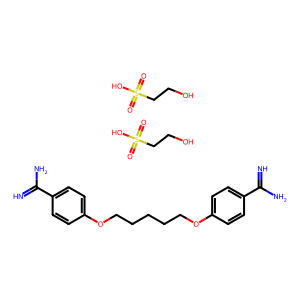

In [86]:
mol = Chem.MolFromSmiles('C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N.C(CS(=O)(=O)O)O.C(CS(=O)(=O)O)O')
Chem.Draw.MolToImage(mol)

In [88]:
Chem.MolToSmiles(mol, isomericSmiles=True)

'N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1.O=S(=O)(O)CCO.O=S(=O)(O)CCO'

In [61]:
miss_smile

{'pentamidine isethionate': 'C1=CC(=CC=C1C(=N)N)OCCCCCOC2=CC=C(C=C2)C(=N)N.C(CS(=O)(=O)O)O.C(CS(=O)(=O)O)O',
 'octreotide': None,
 'rasburicase': None,
 'insulin glargine': None,
 'tiotropium bromide': 'C[N+]1([C@@H]2CC(C[C@H]1[C@H]3[C@@H]2O3)OC(=O)C(C4=CC=CS4)(C5=CC=CS5)O)C.[Br-]',
 'ipratropium bromide': None,
 'eptifibatide': None,
 'exenatide': None,
 'porfimer sodium': None,
 'erythropoietin': 'CCCCC1=NC(=C(N1CC2=CC=C(C=C2)C3=CC=CC=C3C4=NN=N[N-]4)CO)Cl.[K+]',
 'colesevelam': 'CCCCCCCCCCNCC=C.C[N+](C)(C)CCCCCCNCC=C.C=CCN.C1C(O1)CCl.Cl.[Cl-]',
 'colestyramine': None,
 'ofatumumab': None,
 'colestilan': 'CC1=NC=CN1.C1C(O1)CCl',
 'oxaliplatin': 'C1CC[C@H]([C@@H](C1)[NH-])[NH-].C(=O)(C(=O)O)O.[Pt+2]',
 'liraglutide': None,
 'desirudin': None,
 'calcium folinate': None,
 'enfuvirtide': None,
 'sodium phenylbutyrate': None,
 'insulin aspart': None,
 'glatiramer acetate': None,
 'dalteparin': 'CC(=O)NC1C(C(C(OC1O)COS(=O)(=O)O)OC2C(C(C(C(O2)C(=O)O)OC3C(C(C(C(O3)CO)OC4C(C(C(C(O4)C(=O)O)O)O)

In [261]:
drug31['dg_ATC'].isna()

(47, 3)

In [185]:
drug31.head()

,GenericName,dg_smile,dg_ATC
0,alfentanil,CCN1N=NN(CCN2CCC(COC)(CC2)N(C(=O)CC)C2=CC=CC=C...,N01AH02
1,telithromycin,[H][C@@]12[C@@H](C)C(=O)[C@H](C)C[C@@](C)(OC)[...,J01FA15
2,simeprevir,[H][C@]12C[C@]1(NC(=O)[C@]1([H])C[C@H](C[C@@]1...,G01AE10;J05AP05
3,pentamidine isethionate,NaN,NaN
4,penicillamine,[H][C@](N)(C(O)=O)C(C)(C)S,M01CC01


In [ ]:
#用以从pubchem找寻smiles的函数
# 	return maccs_str
def search_from_Pubchem(name):
    time.sleep(1)
    if name == None:
        pass
    else:
        try:
            pubresu = get_compounds(name, 'name')[0]
        except:
            # row['activesubstancename'] = drug
            smiles=None
        else:
            # row['activesubstancename'] = drug
            if pubresu.isomeric_smiles is not None:
                smiles = pubresu.isomeric_smiles
            elif pubresu.canonical_smiles is not None:
                smiles = pubresu.canonical_smiles
            else:
                smiles=None
        return smiles